# Pygcdl Sample Data Creation

In this notebook, we create a diverse set of spatial geometries for testing purposes. These geometries are based on california county boundaries. For each polygon/multipolygon geometry, we also calculate the union / convex hull ratio, as this value is calculated by the pygcdl package when determining how to upload a geometry object.

Part 0: Prepare CA counties dataset </br>
Part 1: Create shapefiles, each containing a subset of CA county boundaries. Geometry types are polygon or multipolygon.</br>
Part 2: Create one shapefile and one csv file containing point data.</br>
Part 3: Create geojson versions of existing geometries.</br>

Description of geometry files created in this notebook: </br>
<i>(Note: zip files contain shapefile files)</i>
- <b>subset_counties1.zip:</b> Five randomly selected counties, all disjoint from each other. Five rows of polygon data. Ratio = 0.125
- <b>subset_counties2.zip:</b> Five counties, all connected. Five rows of polygon data. Ratio = 0.909
- <b>subset_counties3.zip:</b> Nineteen counties, all connected except for one. Nineteen rows of polygon data. Ratio = 0.895
- <b>subset_counties4.zip:</b> One county, multipolygon, with three polygons (includes two islands). One row of data. Ratio = 0.531
- <b>subset_counties5.zip:</b> One multipolygon row with the same counties as subset 2, all connected counties. Ratio = 0.909
- <b>subset_counties6.zip:</b> One polygon, one county. Convex hull ratio is just below 0.8. Ratio = 0.781
- <b>subset_counties7.zip:</b> Two connected counties, but a funky shape with large convex hull. Two rows of polygon data. Ratio = 0.564
- <b>subset_counties8.zip:</b> Same counties as in subset 2 and subset 5, but split into two multipolygon rows. First row contains to disjoint counties. Ratio = 0.909
- <b>county_centroids.zip:</b> Point data of all CA county centroids.
- <b>county_centroids.csv:</b> CSV version of county_centroids.shp
- <b>subset_counties1.geojson:</b> Geojson version of subset_counties1.shp
- <b>subset_counties2.geojson:</b> Geojson version of subset_counties2.shp
- <b>county_centroids.geojson:</b> Geojson version of county_centroids.shp

# Part 0: Prepare CA Counties Dataset

In [1]:
import geopandas as gpd
from pathlib import Path
import random
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import shapely
from shapely.geometry import MultiPolygon
import urllib.request
pd.options.mode.chained_assignment = None  # default='warn'
import shutil

In [2]:
# Download and unzip CA county boundaries data
download_dir = Path("input_data")
download_dir.mkdir(exist_ok=True)
download_file = Path("input_data/ca_counties.zip")
urllib.request.urlretrieve("https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/b0007416-a325-4777-9295-368ea6b710e6/download/ca_counties.zip", download_file)
with zipfile.ZipFile(download_file, 'r') as z:
    z.extractall(path=download_dir)
counties_shp_path = Path("input_data/ca_counties.shp")

In [3]:
# Define paths and read in county data
random.seed(12345)
output_dir = Path.cwd() / "output_data"
output_dir.mkdir(exist_ok=True)
counties = gpd.read_file(counties_shp_path)
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2.468695e+09,2.329911e+07,+39.5769252,-120.5219926,375602.758281,4.200450e+09,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2.499984e+09,7.542543e+07,+38.4500161,-121.3404408,406584.174167,4.205516e+09,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-13440081.316 4150394.004, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2.641785e+09,4.384187e+07,+38.1838996,-120.5614415,367005.879680,4.356213e+09,"POLYGON ((-13428575.483 4627725.227, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-13283668.940 4059436.934, -13..."


In [4]:
# Remove all unnecessary columns
counties = counties[["NAME", "geometry"]]
counties.head()

,NAME,geometry
0,Sierra,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,Sacramento,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,Santa Barbara,"MULTIPOLYGON (((-13440081.316 4150394.004, -13..."
3,Calaveras,"POLYGON ((-13428575.483 4627725.227, -13428534..."
4,Ventura,"MULTIPOLYGON (((-13283668.940 4059436.934, -13..."


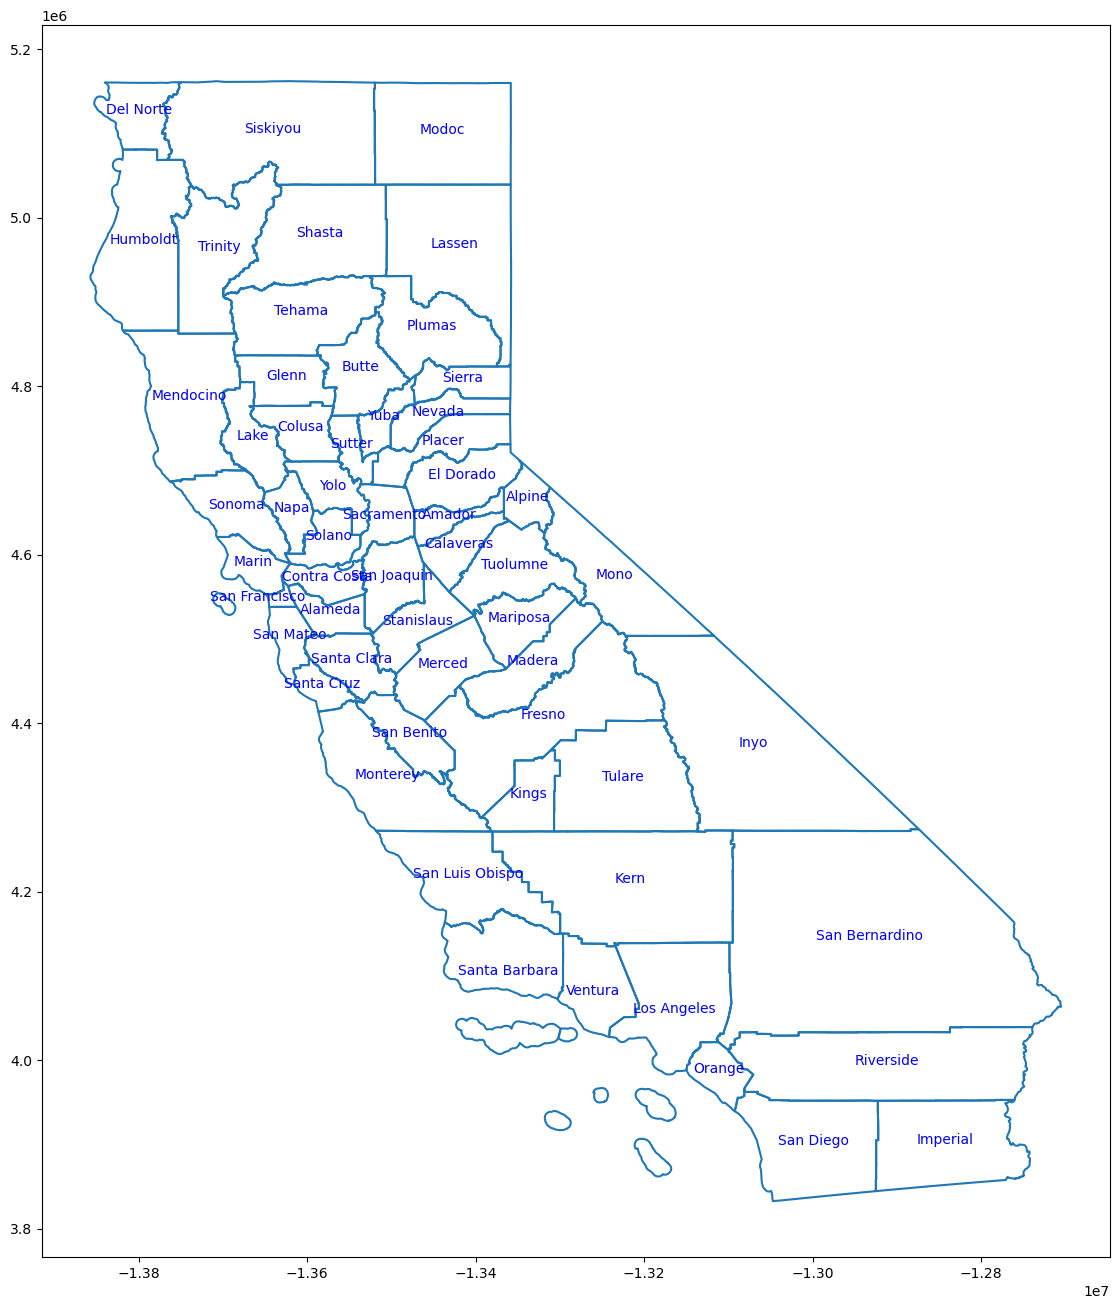

In [5]:
# Visualize all counties with county names
counties["centroid"] = counties["geometry"].centroid
fig, ax = plt.subplots(figsize=(20, 16))
counties.boundary.plot(ax=ax)
for idx, row in counties.iterrows():
    plt.annotate(text=row["NAME"], xy=(row["centroid"].x, row["centroid"].y), horizontalalignment='center', color='blue')
counties = counties.drop(["centroid"], axis=1) # remove row when done using it

In [6]:
# We see here that our CRS is projected and in units of meters
counties.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# Simplify the data to reduce the size of files produced.
# First add a buffer of 100 meters to each polygon,
# then use the GeoSeries.simplify() function with a tolerance of 100
# meters to decrease the total number of coordinates in each polygon
buffered_counties = counties[["geometry","NAME"]]
buffered_counties["geometry"] = buffered_counties["geometry"].buffer(100) # buffer by 100 meters
simplified_counties = buffered_counties
simplified_counties["geometry"] = simplified_counties["geometry"].simplify(tolerance=100)

We want to see how this buffering and simplifying affects our county boundaries to ensure it doesn't have too significant of an effect. Here, we plot the original boundaries of Santa Cruz county in blue, and superimpose the buffered and simplified boundaries of Santa Cruz county in red. You can see that the polygons are very similar, and the red boundaries lay ever so slightly outside the blue boundaries.

<Axes: >

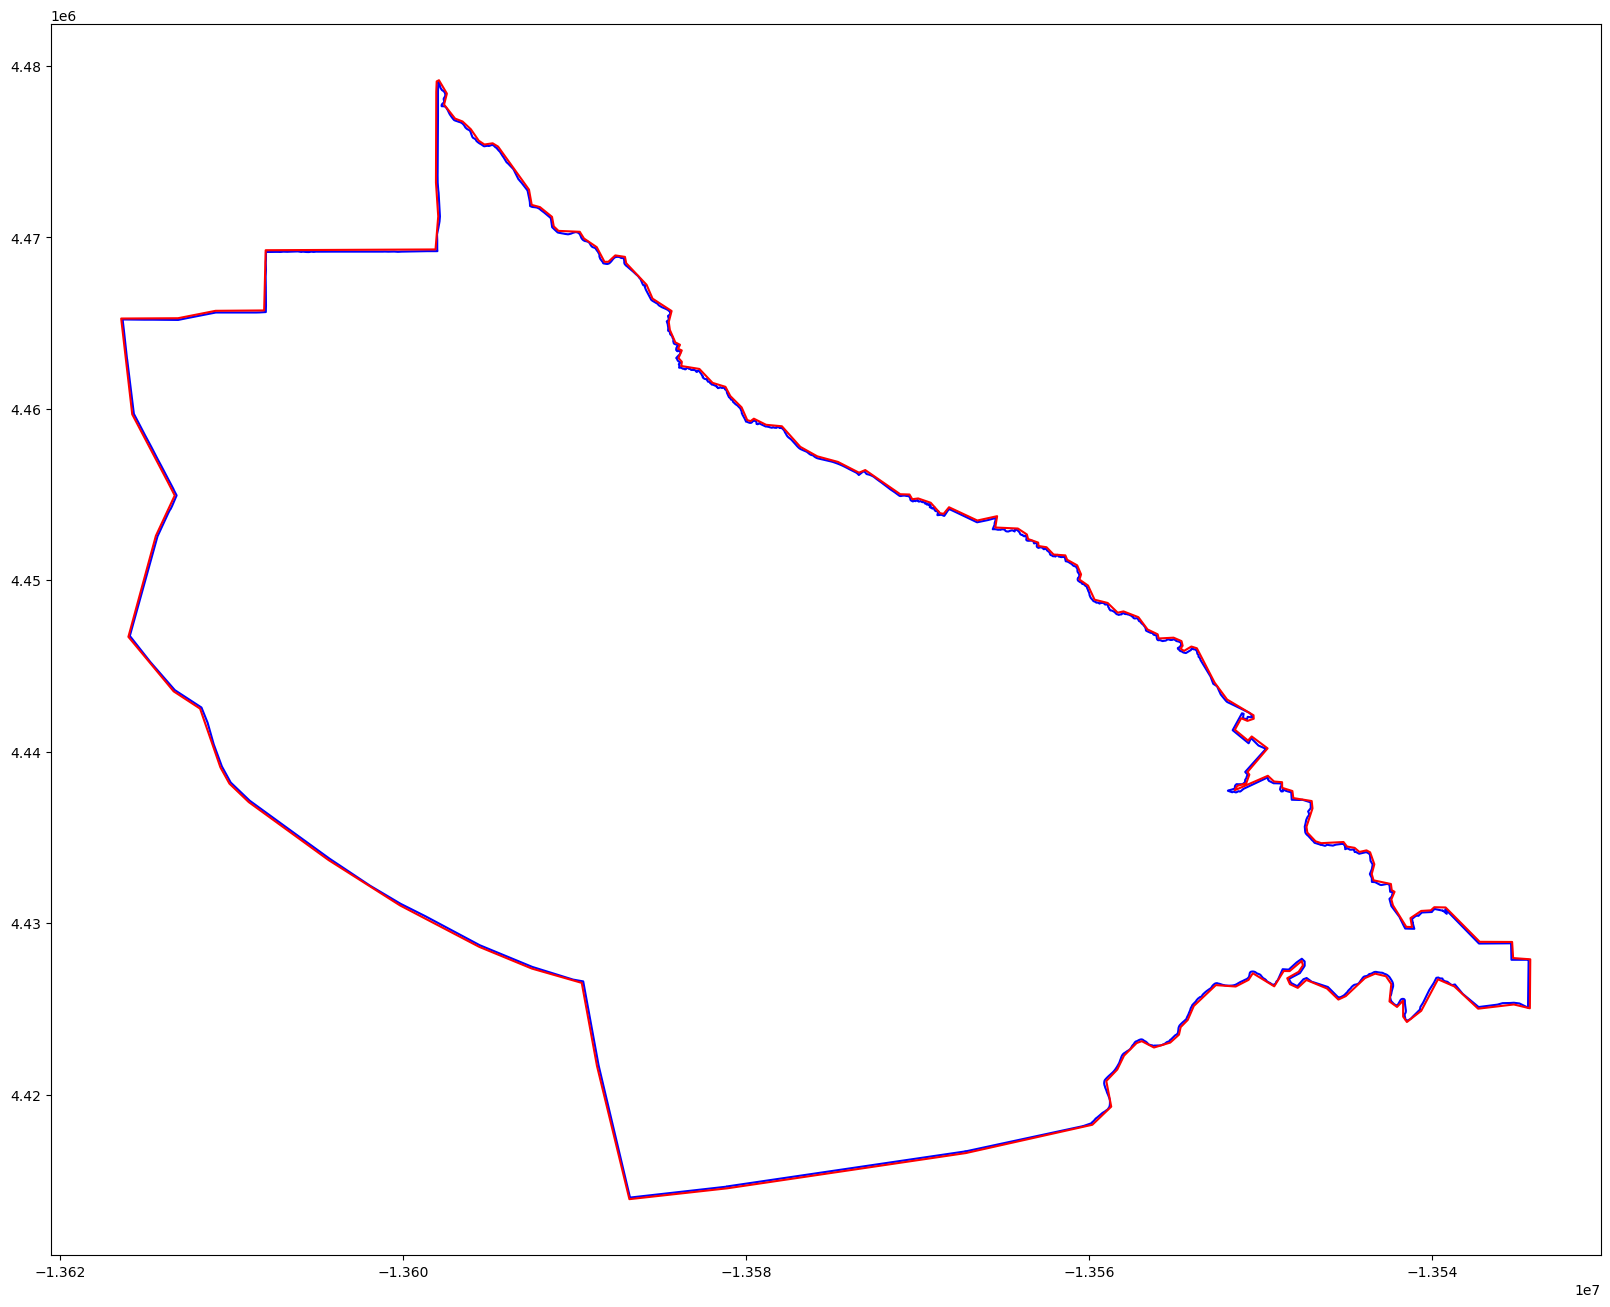

In [8]:
# Visually compare one small county before and after this simplification
fig, ax = plt.subplots(figsize=(20,20))
counties.loc[counties["NAME"] == "Santa Cruz"].boundary.plot(ax=ax, color="blue")
simplified_counties.loc[simplified_counties["NAME"] == "Santa Cruz"].boundary.plot(ax=ax, color="red")

Next, we want to confirm that this simplification process has indeed decreased the size of our data. We will compare the total number of coordinates in the original county boundaries geodataframe with the simplified counties geodataframe.

In [9]:
coords_original = counties["geometry"].get_coordinates()
num_coords_original = len(coords_original)
coords_simplified = simplified_counties["geometry"].get_coordinates()
num_coords_simplified = len(coords_simplified)
print("Original number of coordinates: ", num_coords_original)
print("Simplified number of coordinates: ", num_coords_simplified)
print("Decreased the number of coordinates to ", round((num_coords_simplified / num_coords_original)*100, ndigits=2), "% of the original")

Original number of coordinates:  241204
Simplified number of coordinates:  18814
Decreased the number of coordinates to  7.8 % of the original


As our last preparatory step, we define a function that will calculate the polygon union / convex hull ratio.

In [10]:
def union_convex_hull_ratio(gdf = gpd.GeoDataFrame):
    union_polygon = gdf.unary_union
    union_area = union_polygon.area
    convex_hull_area = union_polygon.convex_hull.area
    ratio = round(union_area / convex_hull_area, ndigits=3)
    return ratio

# Part 1: Creating county polygon subsets

##### Subset counties 1: Five randomly selected counties, all disjoint from each other. Five rows of polygon data. Ratio = 0.124

Union / Convex Hull ratio:  0.125


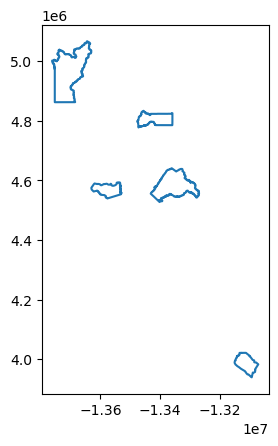

In [11]:
# Pick five random counties for subset 1 and plot them
county_indicies = range(len(simplified_counties))
county_indicies1 = random.choices(county_indicies, k=5)
subset_counties1 = simplified_counties.iloc[county_indicies1]
subset_counties1.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties1))

In [12]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties1")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties1.to_file(zip_dir/"subset_counties1.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties1.cpg                           2024-05-10 15:20:18           10
subset_counties1.dbf                           2024-05-10 15:20:18          471
subset_counties1.prj                           2024-05-10 15:20:18          425
subset_counties1.shp                           2024-05-10 15:20:18        33440
subset_counties1.shx                           2024-05-10 15:20:18          140


##### Subset counties 2

Union / Convex Hull ratio:  0.909


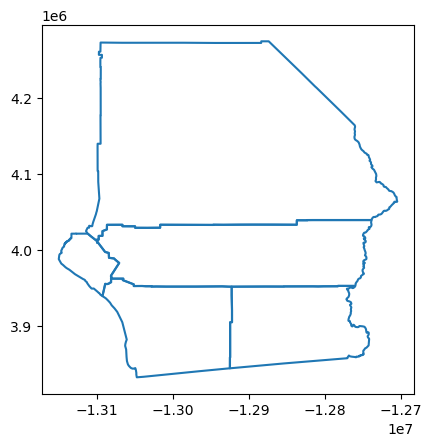

In [13]:
# Define counties in subset 2 and plot
county_names2 = ["San Bernardino", "Orange", "Riverside", "San Diego", "Imperial"]
subset_counties2 = simplified_counties[simplified_counties["NAME"].isin(county_names2)]
subset_counties2.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties2))

In [14]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties2")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties2.to_file(zip_dir/"subset_counties2.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties2.cpg                           2024-05-10 15:20:20           10
subset_counties2.dbf                           2024-05-10 15:20:20          471
subset_counties2.prj                           2024-05-10 15:20:20          425
subset_counties2.shp                           2024-05-10 15:20:20        10844
subset_counties2.shx                           2024-05-10 15:20:20          140


##### Subset counties 3

Union / Convex Hull ratio:  0.895


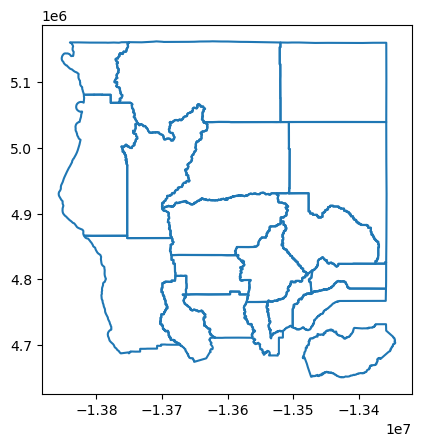

In [15]:
# Define counties in subset 3
county_names3 = ["Del Norte", "Siskiyou", "Modoc", "Humboldt", "Trinity", "Shasta", "Lassen", "Tehama", "Plumas", "Butte", "Glenn", "Mendocino", "Lake", "Colusa", "Sutter", "Yuba", "Nevada", "Sierra", "El Dorado"]
subset_counties3 = simplified_counties[simplified_counties["NAME"].isin(county_names3)]
subset_counties3.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties3))

In [16]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties3")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties3.to_file(zip_dir/"subset_counties3.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties3.cpg                           2024-05-10 15:20:20           10
subset_counties3.dbf                           2024-05-10 15:20:20         1605
subset_counties3.prj                           2024-05-10 15:20:20          425
subset_counties3.shp                           2024-05-10 15:20:20       110092
subset_counties3.shx                           2024-05-10 15:20:20          252


##### Subset counties 4

Union / Convex Hull ratio:  0.531


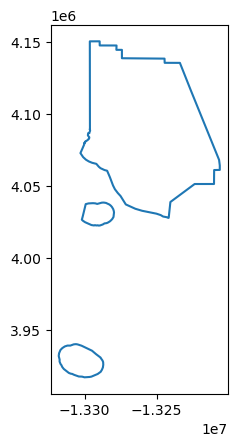

In [17]:
# Define one county for subset 4
county_names4 = ["Ventura"]
subset_counties4 = simplified_counties[simplified_counties["NAME"].isin(county_names4)]
subset_counties4.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties4))

In [18]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties4")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties4.to_file(zip_dir/"subset_counties4.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties4.cpg                           2024-05-10 15:20:20           10
subset_counties4.dbf                           2024-05-10 15:20:20          147
subset_counties4.prj                           2024-05-10 15:20:20          425
subset_counties4.shp                           2024-05-10 15:20:20         2436
subset_counties4.shx                           2024-05-10 15:20:20          108


##### Subset counties 5

Union / Convex Hull ratio:  0.909


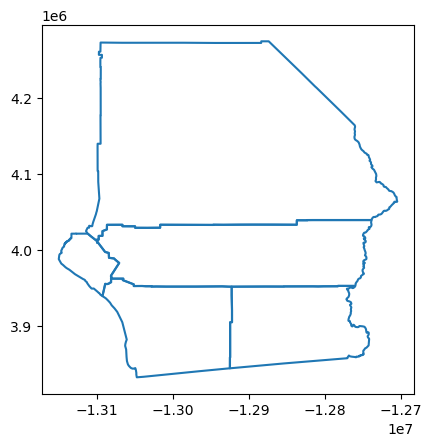

In [19]:
# Create a single multipolygon row with the same counties as subset 2, all connected
multipolygon_geometry = [subset_counties2.iloc[i, subset_counties2.columns.get_loc("geometry")] for i in range(len(subset_counties2))]
multipolygon_geometry = MultiPolygon(multipolygon_geometry)
type(multipolygon_geometry)
subset_counties5 = gpd.GeoDataFrame(index = [0], crs = subset_counties2.crs, geometry=[multipolygon_geometry])
subset_counties5.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties5))

In [20]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties5")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties5.to_file(zip_dir/"subset_counties5.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties5.cpg                           2024-05-10 15:20:20           10
subset_counties5.dbf                           2024-05-10 15:20:20           78
subset_counties5.prj                           2024-05-10 15:20:20          425
subset_counties5.shp                           2024-05-10 15:20:20        10636
subset_counties5.shx                           2024-05-10 15:20:20          108


##### Subset counties 6

Union / Convex Hull ratio:  0.781


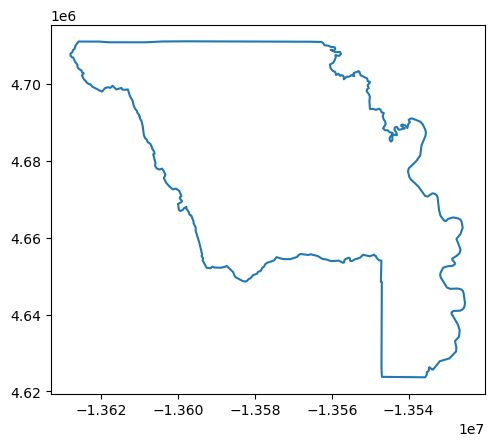

In [21]:
county_names6 = ["Yolo"]
subset_counties6 = simplified_counties[simplified_counties["NAME"].isin(county_names6)]
subset_counties6.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties6))

In [22]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties6")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties6.to_file(zip_dir/"subset_counties6.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties6.cpg                           2024-05-10 15:20:22           10
subset_counties6.dbf                           2024-05-10 15:20:22          147
subset_counties6.prj                           2024-05-10 15:20:22          425
subset_counties6.shp                           2024-05-10 15:20:22         5404
subset_counties6.shx                           2024-05-10 15:20:22          108


##### Subset counties 7

Union / Convex Hull ratio:  0.564


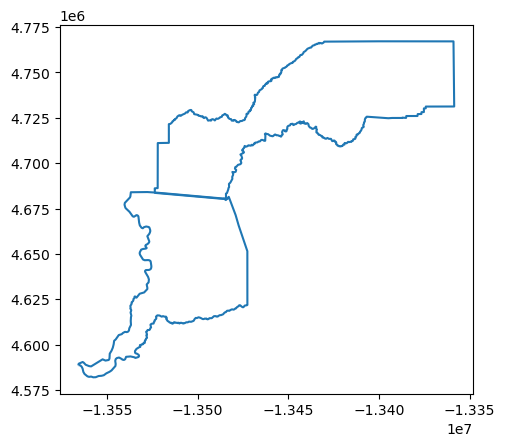

In [23]:
county_names7 = ["Placer", "Sacramento"]
subset_counties7 = simplified_counties[simplified_counties["NAME"].isin(county_names7)]
subset_counties7.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties7))

In [24]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties7")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties7.to_file(zip_dir/"subset_counties7.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties7.cpg                           2024-05-10 15:20:22           10
subset_counties7.dbf                           2024-05-10 15:20:22          228
subset_counties7.prj                           2024-05-10 15:20:22          425
subset_counties7.shp                           2024-05-10 15:20:22        11620
subset_counties7.shx                           2024-05-10 15:20:22          116


##### Subset counties 8

Union / Convex Hull ratio:  0.125


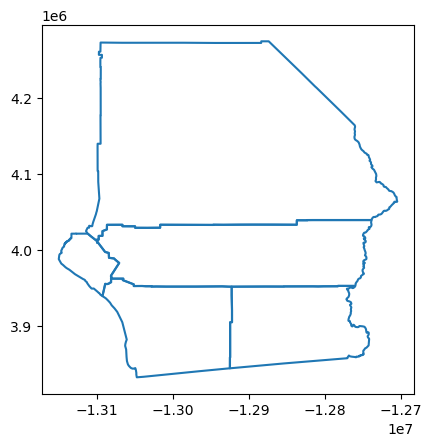

In [25]:
multipolygon_geometry1 = [subset_counties2.iloc[i, subset_counties2.columns.get_loc("geometry")] for i in [0,1]]
multipolygon_geometry1 = MultiPolygon(multipolygon_geometry1)
multipolygon_geometry2 = [subset_counties2.iloc[i, subset_counties2.columns.get_loc("geometry")] for i in [2,3,4]]
multipolygon_geometry2 = MultiPolygon(multipolygon_geometry2)
subset_counties8 = gpd.GeoDataFrame(index = [0,1], crs = subset_counties2.crs, geometry=[multipolygon_geometry1, multipolygon_geometry2])
subset_counties8.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties1))

<Axes: >

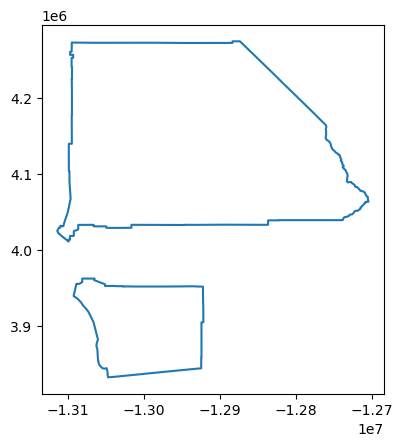

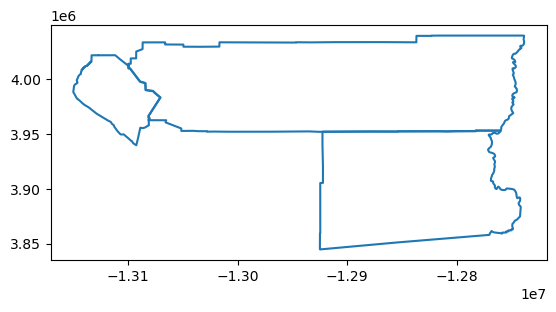

In [26]:
# Show that the first row has two disjoint polygons
subset_counties8.loc[[0],'geometry'].boundary.plot()
subset_counties8.loc[[1],'geometry'].boundary.plot()

In [27]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"subset_counties8")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
subset_counties8.to_file(zip_dir/"subset_counties8.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
subset_counties8.cpg                           2024-05-10 15:20:22           10
subset_counties8.dbf                           2024-05-10 15:20:22           90
subset_counties8.prj                           2024-05-10 15:20:22          425
subset_counties8.shp                           2024-05-10 15:20:22        10688
subset_counties8.shx                           2024-05-10 15:20:22          116


# Part 2: Creating Point Data

##### Make shapefile of points

<Axes: >

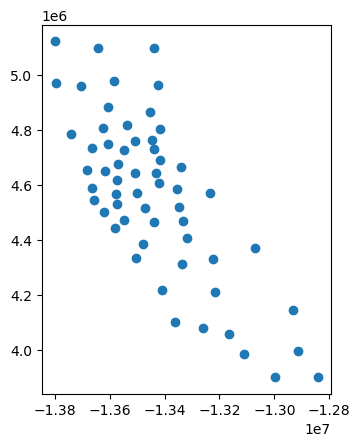

In [28]:
# Create a geodataframe of the centroids of each county
counties["centroid"] = counties["geometry"].centroid
county_centroids = counties.set_geometry("centroid")
county_centroids = county_centroids.drop(columns="geometry")
county_centroids.plot()

In [29]:
# Store all shapefiles in a .zip file

# Create folder to store shapefile files in
zip_dir = Path(output_dir/"county_centroids")
zip_dir.mkdir(exist_ok=True)

# Put shapefiles in folder
county_centroids.to_file(zip_dir/"county_centroids.shp")

# Zip folder
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), 'w') as z:
    for filepath in zip_dir.glob("*.*"):
        z.write(filepath, arcname=filepath.name)

# Delete now unnecessary folder
shutil.rmtree(zip_dir)

# List files in newly created archive
with zipfile.ZipFile(zip_dir.with_suffix(".zip"), "r") as z:
    z.printdir()

File Name                                             Modified             Size
county_centroids.cpg                           2024-05-10 15:20:22           10
county_centroids.dbf                           2024-05-10 15:20:22         4764
county_centroids.prj                           2024-05-10 15:20:22          425
county_centroids.shp                           2024-05-10 15:20:22         1724
county_centroids.shx                           2024-05-10 15:20:22          564


# Make csv file of points

In [30]:
# CSV files don't contain geographic metadata, so we need to take note of the CRS our coordinates are in
# We will specify this CRS when we make our GCDL request to the GCDL knows how to interpret the coordinates
print(county_centroids.crs)

EPSG:3857


In [31]:
# Extract x and y values of points into lists
x_values = [p.x for p in county_centroids["centroid"]]
y_values = [p.y for p in county_centroids["centroid"]]

In [32]:
# Create pandas dataframe from x and y value lists
point_data = pd.DataFrame({"x":x_values, "y":y_values})
point_data.head()

,x,y
0,-1.341578e+07,4.805173e+06
1,-1.350797e+07,4.643182e+06
2,-1.336181e+07,4.101615e+06
3,-1.342000e+07,4.608441e+06
4,-1.326102e+07,4.077218e+06


In [33]:
point_data.to_csv(output_dir / "county_centroids.csv")

# Part 3: Create geojson versions of existing geometries

We will create three geojson files, based on the following existing geometry objects: subset_counties1, subset_counties2, and county_centroids.

In [34]:
subset_counties1.to_file(output_dir / "subset_counties1.geojson", driver="GeoJSON")

In [35]:
subset_counties2.to_file(output_dir / "subset_counties2.geojson", driver="GeoJSON")

In [36]:
county_centroids.to_file(output_dir / "county_centroids.geojson", driver="GeoJSON")